# Basic mapmaking test with $h_n$ functions for 1 detector pair

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from mapbased_syste.mapmaking import FrameworkSystematics
from mapbased_syste.io import read_h_n_file
from mapbased_syste.hn import Spin_maps

# Preparation of the inputs

First we can read the $h_n$ files

In [2]:
path_h_n_files = '/global/cfs/cdirs/sobs/sims/scan-s0001/h_n_maps/'

h_n_names = 'high_cadence_constant_scan_1_el_w13_p000_f150_A'

In [ ]:
h_n_spin_dict_1det = read_h_n_file(path_h_n_files+h_n_names, list_spin=[1,2,3,4])

h_n_spin_dict = dict() # Preparing the dictionary for the pair of detectors

for key, element in h_n_spin_dict_1det.items():
    new_h_n_maps = np.vstack([element, element * np.exp(1j * key * np.pi/2)]).squeeze()/2. # The /2. factor is to normalize the hits, and the stacking is done on the h_n maps of 1 detector and the rotated h_n maps by a factor pi/2
    h_n_spin_dict[key] = new_h_n_maps

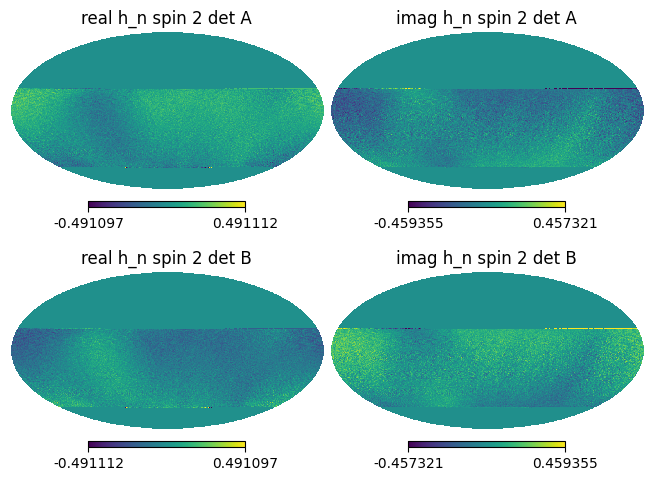

In [ ]:
# Plotting an example of the h_n maps for a pair of detectors for spin 2
spin_ = 2

hp.mollview(h_n_spin_dict[spin_][0].real, title=f'real h_n spin {spin_} det A', sub=(2,2,1))
hp.mollview(h_n_spin_dict[spin_][0].imag, title=f'imag h_n spin {spin_} det A', sub=(2,2,2))
hp.mollview(h_n_spin_dict[spin_][1].real, title=f'real h_n spin {spin_} det B', sub=(2,2,3))
hp.mollview(h_n_spin_dict[spin_][1].imag, title=f'imag h_n spin {spin_} det B', sub=(2,2,4))
plt.show()

In [5]:
n_det = h_n_spin_dict[0].shape[0]

Build a mask from the $h_n$ files

/global/homes/m/mag/.conda/envs/beams_env/lib/python3.10/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


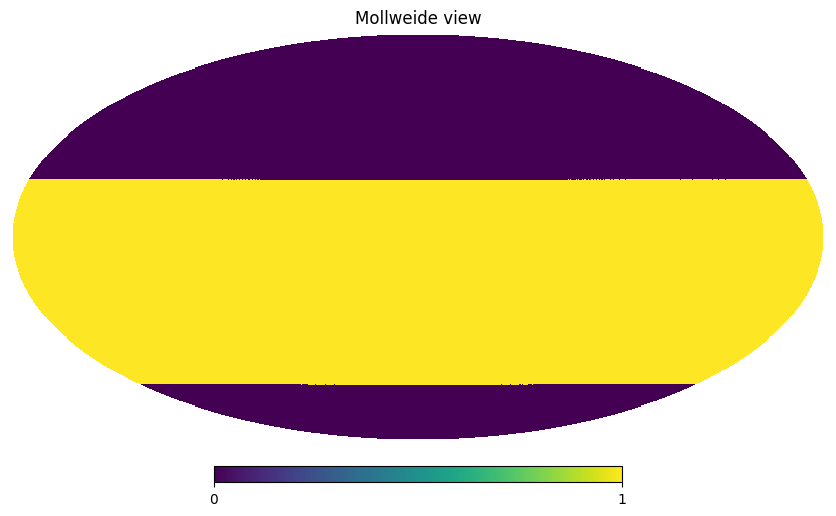

In [6]:
mask = np.zeros_like(h_n_spin_dict[2][0,...])
mask[h_n_spin_dict[2][0,...] != 0] = 1

hp.mollview(mask)

Then create the `FrameworkSystematics` object

In [7]:
nstokes = 3

In [8]:
nside = hp.npix2nside(h_n_spin_dict[2][0,...].size)

syste_object = FrameworkSystematics(nside=nside, nstokes=nstokes, lmax=2*nside, list_spin_output=[0,-2,2])

Prepare the input sky maps

In [9]:
%%time
spin_sky_maps = syste_object.get_spin_sky_maps()

spin_sky_maps = {spin:spin_sky_maps[spin]*mask for spin in spin_sky_maps.keys()}

Calculating spectra from CAMB !
CPU times: user 31min 42s, sys: 6.88 s, total: 31min 49s
Wall time: 33.5 s


Plotting the real and imaginary part of the spin $2$, $-2$ maps

/global/homes/m/mag/.conda/envs/beams_env/lib/python3.10/site-packages/healpy/projector.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


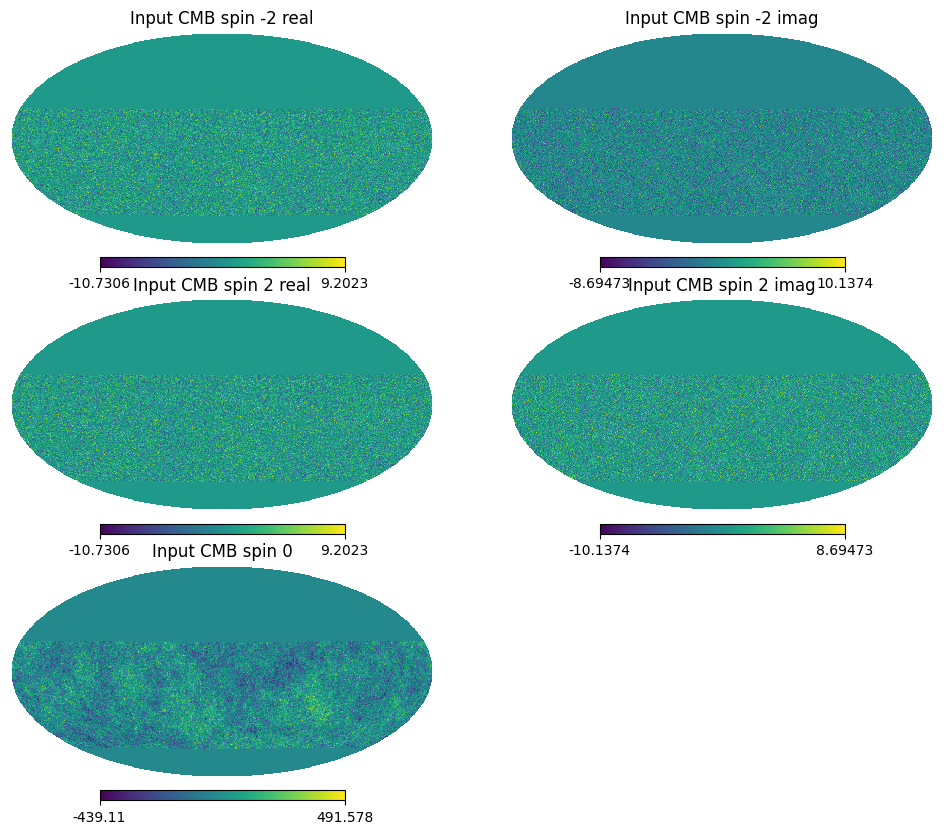

In [10]:
plt.figure(figsize=(10,8))
hp.mollview(spin_sky_maps[-2].real, sub=(3,2,1), title='Input CMB spin -2 real') #, min=-5, max=5
hp.mollview(spin_sky_maps[-2].imag, sub=(3,2,2), title='Input CMB spin -2 imag')
hp.mollview(spin_sky_maps[2].real, sub=(3,2,3), title='Input CMB spin 2 real')
hp.mollview(spin_sky_maps[2].imag, sub=(3,2,4), title='Input CMB spin 2 imag')
hp.mollview(spin_sky_maps[0], sub=(3,2,5), title='Input CMB spin 0')

Checking the $Q$ and $U$ Stokes parameters of those spin maps

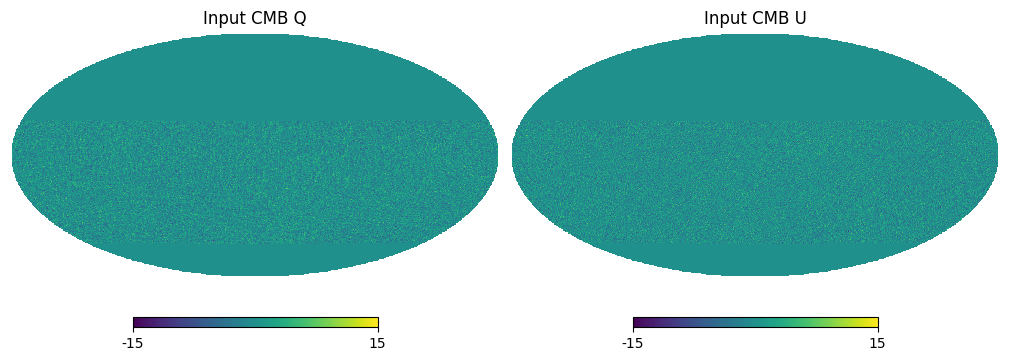

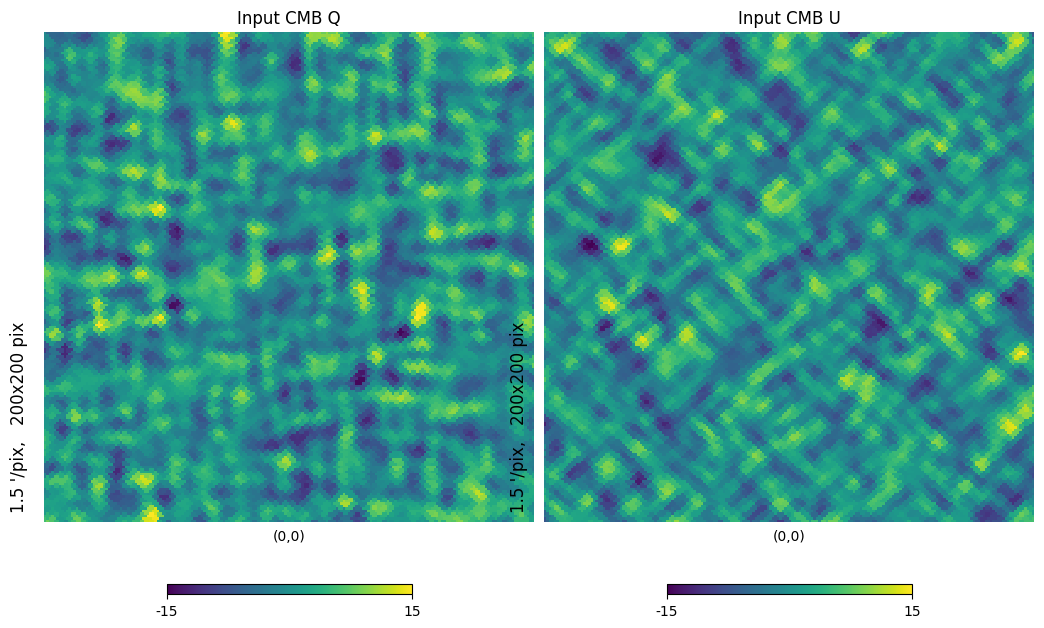

In [11]:
value = 15
plt.figure(figsize=(10,8))
hp.mollview((spin_sky_maps[2].real + spin_sky_maps[-2].real)/2, sub=(1,2,1), title='Input CMB Q', min=-value, max=value)
hp.mollview((spin_sky_maps[2].imag - spin_sky_maps[-2].imag)/2, sub=(1,2,2), title='Input CMB U', min=-value, max=value)

plt.figure(figsize=(10,8))
hp.gnomview(spin_sky_maps[2].real + spin_sky_maps[-2].real, sub=(1,2,1), title='Input CMB Q', min=-value, max=value)
hp.gnomview(spin_sky_maps[2].imag - spin_sky_maps[-2].imag, sub=(1,2,2), title='Input CMB U', min=-value, max=value)
plt.show()


For this basic mapmaking, we do not include systematics

In [12]:
spin_systematics_maps = Spin_maps.from_dictionary({spin: np.zeros((n_det,)+ spin_sky_maps[spin].shape) for spin in spin_sky_maps.keys()} )
# The systematics must have the structure {spin: array[ndet, npix]}
# In this case we are simulating only one detector

## Mapmaking

We can finally perform mapmaking

In [13]:
h_n_spin_dict[-2].shape, spin_systematics_maps[2].shape

((2, 12582912), (2, 12582912))

In [14]:
%%time
final_maps, inverse_mapmaking_matrix = syste_object.compute_total_maps(mask, h_n_spin_dict, spin_sky_maps, spin_systematics_maps, return_inverse_mapmaking_matrix=True)

Coupled spins for spin 0: [(2, -2), (0, 0), (-2, 2)]
Coupled spins for spin 2: [(4, -2), (2, 0), (0, 2)]
Coupled spins for spin -2: [(0, -2), (-2, 0), (-4, 2)]
CPU times: user 58.6 s, sys: 8.04 s, total: 1min 6s
Wall time: 39.8 s


And form from the obtained maps the final $Q$ and $U$ maps

In [16]:
final_T_map = final_maps[0]
final_Q_map = (final_maps[-2] + final_maps[2])/2.
final_U_map = 1j*(final_maps[-2] - final_maps[2])/2.

We can plot them, both the real and imaginary parts for sanity tests

In [17]:
extended_final_maps = np.zeros((nstokes,12*nside**2), dtype=complex)
extended_final_maps[0, mask != 0] = final_T_map.real
extended_final_maps[1, mask != 0] = final_Q_map.real
extended_final_maps[2, mask != 0] = final_U_map.real

extended_final_maps_imag = np.zeros((nstokes,12*nside**2), dtype=complex)
extended_final_maps_imag[0, mask != 0] = final_T_map.imag
extended_final_maps_imag[1, mask != 0] = final_Q_map.imag
extended_final_maps_imag[2, mask != 0] = final_U_map.imag

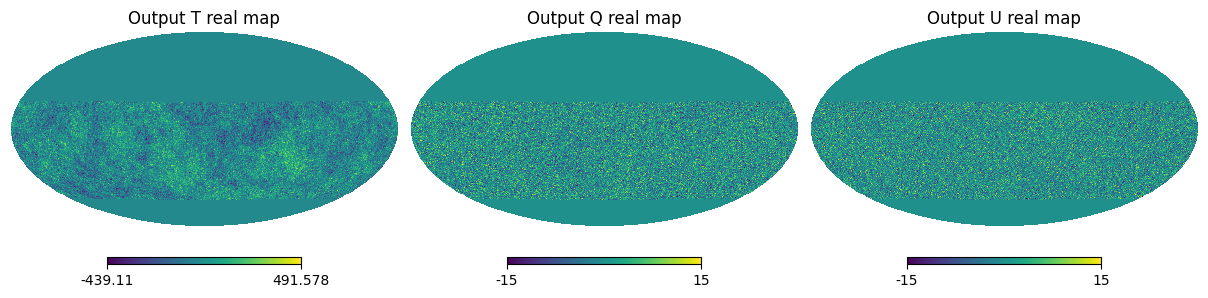

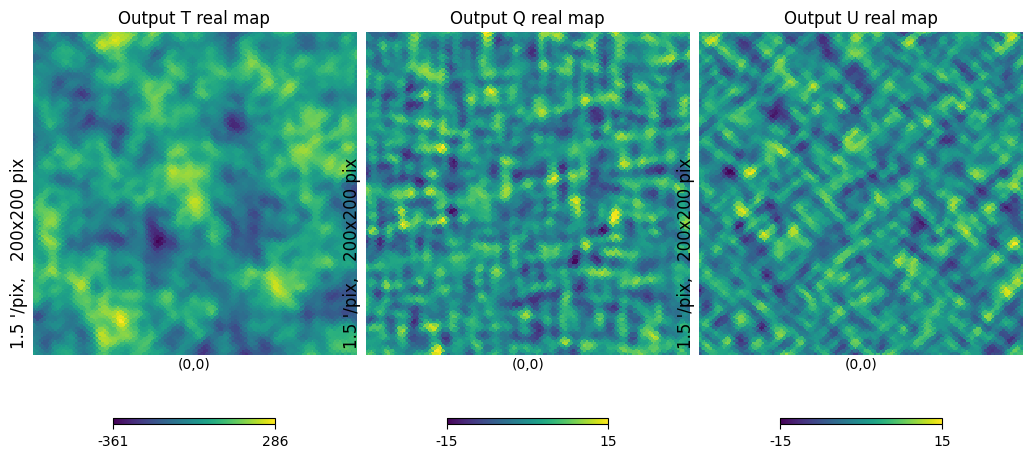

In [18]:
value = 15
plt.figure(figsize=(12,6))
hp.mollview(extended_final_maps[0], sub=(1,nstokes,1), title='Output T real map')
hp.mollview(extended_final_maps[1], sub=(1,nstokes,2), title='Output Q real map', min=-value, max=value)
hp.mollview(extended_final_maps[2], sub=(1,nstokes,3), title='Output U real map', min=-value, max=value)

plt.figure(figsize=(10,8))
hp.gnomview(extended_final_maps[0], sub=(1,nstokes,1), title='Output T real map')
hp.gnomview(extended_final_maps[1], sub=(1,nstokes,2), title='Output Q real map', min=-value, max=value)
hp.gnomview(extended_final_maps[2], sub=(1,nstokes,3), title='Output U real map', min=-value, max=value)


Note that the imaginary maps are supposed to be $0$

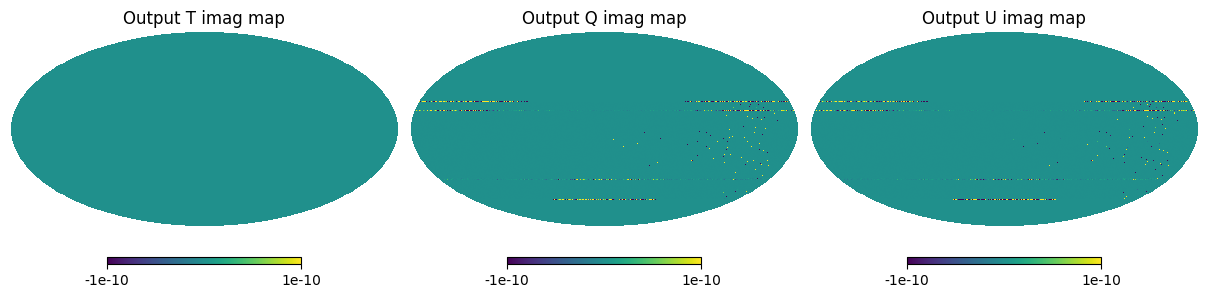

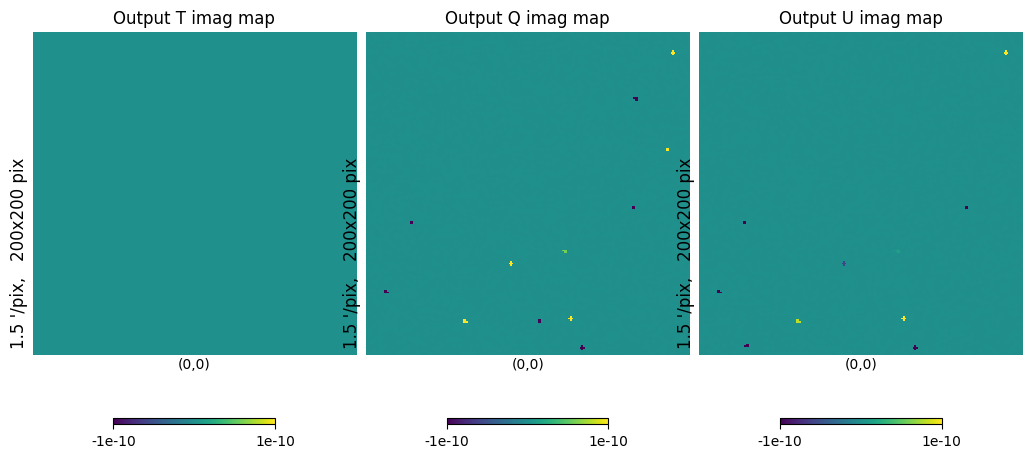

In [19]:
value = 1e-10
plt.figure(figsize=(12,6))
hp.mollview(extended_final_maps_imag[0], sub=(1,nstokes,1), title='Output T imag map', min=-value, max=value)
hp.mollview(extended_final_maps_imag[1], sub=(1,nstokes,2), title='Output Q imag map', min=-value, max=value)
hp.mollview(extended_final_maps_imag[2], sub=(1,nstokes,3), title='Output U imag map', min=-value, max=value)
plt.show()


plt.figure(figsize=(10,8))
hp.gnomview(extended_final_maps_imag[0], sub=(1,nstokes,1), title='Output T imag map', min=-value, max=value)
hp.gnomview(extended_final_maps_imag[1], sub=(1,nstokes,2), title='Output Q imag map', min=-value, max=value)
hp.gnomview(extended_final_maps_imag[2], sub=(1,nstokes,3), title='Output U imag map', min=-value, max=value)
plt.show()


This simply denotes bad condition number for the mapmaking matrix, please check the `advanced_mapmaking_1det.ipynb` notebook for more details about this. A mask based on this or the nhits should be enough to regularize the output maps (or the addition of more detectors). 